# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import glob
import os


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Loading the Data

In [3]:
directory = './trainfolders/'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory, labels='inferred', label_mode='int',
    color_mode='rgb', batch_size=100, image_size=(40,
    40), shuffle=True, seed=42, validation_split=0.2, subset="training"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory, labels='inferred', label_mode='int',
    color_mode='rgb', batch_size=100, image_size=(40,
    40), shuffle=True, seed=42, validation_split=0.2, subset="validation"
)

testdirectory = './testfolders/'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    testdirectory, labels='inferred', label_mode='int',
    color_mode='rgb', batch_size=100, image_size=(40,
    40), shuffle=True, seed=42,
)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.
Found 12630 files belonging to 43 classes.


In [4]:
class_names = train_ds.class_names
class_names

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '5',
 '6',
 '7',
 '8',
 '9']

In [5]:
# (train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.mnist.load_data() 
# # (train_images, train_labels), (test_images,test_labels) = (train_images[:5000], train_labels[:5000]), (test_images[:1000],test_labels[:1000])

# print(train_images.shape, train_labels.shape)
# print(test_images.shape, test_labels.shape)

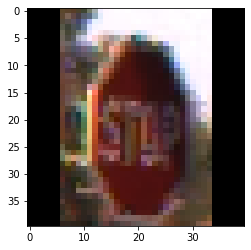

In [6]:
get = next(iter(test_ds))

plt.imshow(get[0][0].numpy().astype("uint8"))
# plt.imshow(train_images[0]);

In [7]:
for img_batch, labels_Batch in train_ds:
    print(img_batch.shape)
    print(labels_Batch.shape)
    break

(100, 40, 40, 3)
(100,)


In [8]:
# train_images = train_images.reshape(train_images.shape[0], 28, 28, -1)

In [9]:
# train_images = (train_images - 127.5)/127.5

In [10]:
BUFFER_SIZE = 1024 #train_images.shape[0]
BATCH_SIZE= 100
train_dataset = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE) # tf.data.Dataset.from_tensor_slices(train_images) \


### DISCRIMINATOR MODEL

In [11]:
def make_descriminator_model():
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(7,(3,3), padding='same', input_shape=(40,40,3)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dense(50, activation="relu"))
    model.add(tf.keras.layers.Dense(43))
    
    return model

In [12]:
model_discriminator = make_descriminator_model()

In [13]:
model_discriminator(np.random.rand(1,40,40,3).astype('float32'))

<tf.Tensor: shape=(1, 43), dtype=float32, numpy=
array([[-0.10525051,  0.34725666, -0.3479429 ,  0.21346654,  0.45212832,
        -0.11833999,  0.07178143,  0.25332758, -0.37054697,  0.13690707,
         0.4571669 , -0.02137547,  0.03479929,  0.0074733 ,  0.07070098,
         0.13910455, -0.20137872,  0.07621987,  0.00979523, -0.3355279 ,
         0.11737906, -0.14438708,  0.11762556, -0.23418641, -0.12413864,
        -0.3555023 ,  0.12140258, -0.30816674, -0.10323498,  0.14153332,
        -0.07671395, -0.01279649, -0.14324719, -0.23404512,  0.46843472,
         0.19623314, -0.33779797, -0.13709903, -0.29819334, -0.04665984,
        -0.0385272 ,  0.03560053, -0.40188327]], dtype=float32)>

In [14]:
np.argmax(model_discriminator(np.random.rand(1,40,40,3).astype('float32')))

22

In [15]:
disriminator_optimizer = tf.optimizers.Adam(1e-3)

In [16]:
def get_descriminator_loss(real_predictions, fake_predictions):
    real_predictions = tf.sigmoid(real_predictions)
    fake_predictions = tf.sigmoid(fake_predictions)
    
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_predictions), 
                                              real_predictions)
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_predictions),
                                              fake_predictions)
    
    return fake_loss + real_loss




## Generator

In [17]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    # H=7, W=7, filters=256  input_shape is random 100 numbers as a input
    model.add(tf.keras.layers.Dense(10*10*256, input_shape=(100,))) 
    
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Reshape( (10,10,256) ))
    assert model.output_shape == (None, 10, 10, 256)  # Note: None is the batch size
    
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (3,3), padding='same'))
    assert model.output_shape == (None, 10, 10, 128)
    
    model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Reshape())
    model.add(tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
    assert model.output_shape == (None, 20, 20, 64)
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3, (3,3), strides=(2,2), padding='same'))
    print(model.output_shape)
    assert model.output_shape == (None, 40, 40, 3)
    
    return model

    

In [18]:
generator = make_generator_model()

(None, 40, 40, 3)


In [19]:
generator_optimizer = tf.optimizers.Adam(1e-4)

In [20]:
def get_generator_loss(fake_predictions):
    fake_predictions = tf.sigmoid(fake_predictions)
    
    fake_loss = tf.losses.binary_crossentropy(tf.ones_like(fake_predictions)\
                                              , fake_predictions)
    return fake_loss

# Training 

In [21]:
def train(dataset, epochs):
    
    for epoch in range(epochs):
        
        for images in dataset:
#             images = tf.cast(images, tf.dtypes.float32)  
#             if images.shape == (68,32)
            if images[0].shape[0] == 100:
                train_step(images,epoch)
            
            

In [22]:
def train_step(images, epoch):
    fake_image_noise = np.random.randn(BATCH_SIZE, 100).astype('float32')
    '''Tensorflow way of making/dealing with gradient 
        pull out gradient and to interatively use it '''
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # With generator let's generate the images and pass some random noise
        generated_images = generator(fake_image_noise)
        
#         plt.imshow(generated_images[0][0])
        # let see how our discriminator works for real and generated images 
        real_output = model_discriminator(images)
        fake_output = model_discriminator(generated_images)
#         print(real_output.shape, fake_output.shape)
        
#         # calculate the loss of generator
        gen_loss = get_generator_loss(fake_output)
        
#         # calculate the loss of discriminator
        disc_loss = get_descriminator_loss(real_output, fake_output)
        
        gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradient_of_discriminator = disc_tape.gradient(disc_loss
                                                       , model_discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(gradient_of_generator
                                                , generator.trainable_variables))
        disriminator_optimizer.apply_gradients(zip(gradient_of_discriminator
                                                  , model_discriminator.trainable_variables))
        if epoch % 2 == 0:
            pass
            print('generator loss: ', np.mean(gen_loss))
            print('discriminator loss: ', np.mean(disc_loss))
        
#         now need to use optimizer to optimize the weights 

In [23]:
train(train_ds, 40)

generator loss:  0.6943003
discriminator loss:  7.536416
generator loss:  0.69594365
discriminator loss:  5.2811646
generator loss:  0.6979731
discriminator loss:  4.5415206
generator loss:  0.70024604
discriminator loss:  4.4156446
generator loss:  0.70384336
discriminator loss:  4.1459465
generator loss:  0.7072816
discriminator loss:  3.9864502
generator loss:  0.7111884
discriminator loss:  3.7824357
generator loss:  0.7150784
discriminator loss:  3.6107602
generator loss:  0.7203829
discriminator loss:  3.3111398
generator loss:  0.72389746
discriminator loss:  3.0274527
generator loss:  0.7300737
discriminator loss:  2.6361566
generator loss:  0.73713654
discriminator loss:  2.6107016
generator loss:  0.7446812
discriminator loss:  2.560341
generator loss:  0.74970174
discriminator loss:  2.5886812
generator loss:  0.7578085
discriminator loss:  2.4712543
generator loss:  0.7611264
discriminator loss:  2.450019
generator loss:  0.77360183
discriminator loss:  2.4323246
generator 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 100)
[[ 1.15114505  0.94710226 -0.94039235  2.87356795 -0.12125999  0.28620197
  -1.11301286 -0.50935026 -0.4466589  -0.03988189 -1.47000132 -0.7489872
   0.1499254   1.61806713  0.66415631  2.17195873  1.63000096  0.37779275
  -0.82060616 -0.6499684   1.02065207 -0.38584537  2.28707306  0.68826464
   0.14200402 -1.54111942 -0.09825281 -1.35787887  0.88587923  0.42644919
   1.56231402 -0.36202619 -1.05590628 -1.04445198  0.09283605  0.1220021
  -0.10629093 -0.18951114 -0.85364178 -2.06971917  1.33443202 -0.69756099
   0.87358354  0.21150319 -0.51593978  0.57465276  0.64043111  0.81798405
   0.61716363  0.08222344 -0.4696484  -0.45779588 -0.23870454  1.39068075
   0.50944701  0.93631029  1.19735767  0.04529268 -0.68098154  1.30591439
   0.64250614 -0.78532437 -1.15721693  0.00331359  0.0278621   0.33537693
   0.22964175  0.22100218  2.27708738  0.06581077  2.04970428 -0.72662243
   0.1232137  -1.79508362  1.51660334 -0.96258924  0.21286715 -0.31335135
   0.39671326 -1.65608821  1.20

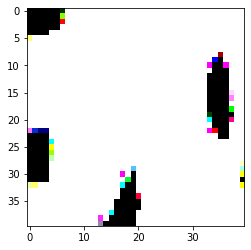

In [24]:
in_digit = np.random.randn(1,100)
print(in_digit.shape)
print(in_digit)
plt.imshow(tf.reshape(generator(in_digit), (40,40,3)))

In [ ]:
# for digit in range(0,10):
# #     in_digit = np.random.randn(1,100)
# #     print(in_digit.shape)
#     plt.imshow(tf.reshape(generator(digit), (28,28)))

In [ ]:
a = tf.ones([3, 4, 3])
print(a.shape)
tf.image.resize_with_crop_or_pad(a, 5, 5)

# The German Traffic Sign Recognition Benchmark

In [ ]:
# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    
    for c in range(0,10): #43
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        print(gtFile)
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        print("Headers:",gtReader.__next__())
        # next(gtReader)
        #gtReader.next() # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

In [ ]:
train_path="GTSRB/Final_Training/Images/"
trainImages, trainLabels = readTrafficSigns(train_path)
print(len(trainLabels), len(trainImages))
plt.imshow(trainImages[42]);
plt.show();

In [ ]:
import tensorflow.compat.v1 as tfGk

In [ ]:
noise_limit = 0.35
noise_l2_weight = 0.02
ADVERSARY_VARIABLES = 'adversary_variables'


In [ ]:
collections = [tfGk.GraphKeys.GLOBAL_VARIABLES, ADVERSARY_VARIABLES]

In [ ]:
x_noise = tf.Variable(tf.zeros([img_size, img_size, num_channels]),
                      name='x_noise', trainable=False,
                      collections=collections)